In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import glob

# --- Step 1: Define File Folder Path ---
folder_path = '/Users/user/Downloads/Women/LFC'  # Folder containing all Excel files
excel_files = glob.glob(os.path.join(folder_path, '*.xlsx'))

# --- Step 2: Define Position & Weight Criteria ---
cb_positions = ['CB', 'LCB', 'RCB']

defensive_stability_weights = {
    'Successful defensive actions per 90': 0.30,
    'Defensive duels won, %': 0.25,
    'Interceptions per 90': 0.15,
    'Sliding tackles per 90': 0.10,
    'Fouls per 90': -0.10,
    'Yellow cards per 90': -0.05,
    'Red cards per 90': -0.05,
}

aerial_dominance_weights = {
    'Aerial duels won, %': 0.35,
    'Aerial duels per 90': 0.25,
    'Height': 0.15,
    'Successful defensive actions per 90': 0.10,
    'Sliding tackles per 90': 0.10,
    'Shots blocked per 90': 0.05,
}

ball_playing_weights = {
    'Accurate passes, %': 0.25,
    'Progressive passes per 90': 0.20,
    'Successful dribbles, %': 0.15,
    'Passes to final third per 90': 0.15,
    'Progressive runs per 90': 0.10,
    'Smart passes per 90': 0.10,
    'Assists per 90': 0.05,
}

# --- Step 3: Scoring Function ---
def calculate_profile_score(df, weights):
    metrics = list(weights.keys())
    missing = [m for m in metrics if m not in df.columns]
    if missing:
        raise ValueError(f"Missing metrics: {missing}")
    
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[metrics])
    weighted = scaled * pd.Series(weights).values
    return weighted.sum(axis=1)

# --- Step 4: Loop Through Files and Apply Scoring ---
all_players = []

for file in excel_files:
    try:
        df = pd.read_excel(file)
        df['Source File'] = os.path.basename(file)  # Track origin

        filtered_df = df[
            (df['Minutes played'] >= 500) &
            (df['Position'].isin(cb_positions))
        ].copy()

        # Skip empty result
        if filtered_df.empty:
            continue

        filtered_df['Defensive_Stability_Score'] = calculate_profile_score(filtered_df, defensive_stability_weights)
        filtered_df['Aerial_Dominance_Score'] = calculate_profile_score(filtered_df, aerial_dominance_weights)
        filtered_df['Ball_Playing_Score'] = calculate_profile_score(filtered_df, ball_playing_weights)

        all_players.append(filtered_df)

    except Exception as e:
        print(f"Failed to process {file}: {e}")

# --- Step 5: Combine and Sort Final Results ---
if all_players:
    final_df = pd.concat(all_players, ignore_index=True)
    ranked_df = final_df.sort_values(by='Defensive_Stability_Score', ascending=False)

    # Display top CBs
    print(ranked_df[['Player', 'Team', 'Position', 'Minutes played', 'Source File',
                     'Defensive_Stability_Score', 'Aerial_Dominance_Score', 'Ball_Playing_Score']].head(10))
else:
    print("No valid players found in any file.")


             Player            Team Position  Minutes played      Source File  \
79   Mireia Masegur           Eibar       CB            1987       Spain.xlsx   
6         J. Olsson  Brommapojkarna      RCB             825      Sweden.xlsx   
50       J. Meißner       SGS Essen      RCB            1432     Germany.xlsx   
133        C. Tappe       Gütersloh      RCB            1064  Germany II.xlsx   
98        B. Gamede    Nordsjælland      RCB             770     Denmark.xlsx   
31      K. Bruhjell           Start      LCB             768   Norway II.xlsx   
135   S. Aunehaugen       Rosenborg      LCB            1063      Norway.xlsx   
144       C. Huseby         Kolbotn      RCB             731      Norway.xlsx   
67   F. Lähteenmäki            Umeå      LCB             645   Sweden II.xlsx   
117    Amaya Garcia  Real Madrid II      LCB             978    Spain II.xlsx   

     Defensive_Stability_Score  Aerial_Dominance_Score  Ball_Playing_Score  
79                    1.028288 

In [5]:
import pandas as pd

# --- Sort and select top 50 ---
top_50 = ranked_df.sort_values(by='Defensive_Stability_Score', ascending=False).head(50)

# --- Select and format relevant columns ---
columns_to_export = [
    'Player', 'Team', 'Position', 'Age', 'Minutes played',
    'Defensive_Stability_Score', 'Aerial_Dominance_Score', 'Ball_Playing_Score',
    'Source File'
]
top_50 = top_50[columns_to_export].copy()

# Round scores for clarity
top_50['Defensive_Stability_Score'] = top_50['Defensive_Stability_Score'].round(2)
top_50['Aerial_Dominance_Score'] = top_50['Aerial_Dominance_Score'].round(2)
top_50['Ball_Playing_Score'] = top_50['Ball_Playing_Score'].round(2)

# --- Save to Excel with styling ---
output_path = 'Top_50_CBs_Economist_Style.xlsx'

with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    top_50.to_excel(writer, sheet_name='Top 50 CBs', index=False)
    
    workbook = writer.book
    worksheet = writer.sheets['Top 50 CBs']
    
    # Format for table (Economist style)
    header_format = workbook.add_format({
        'bold': True,
        'text_wrap': True,
        'valign': 'middle',
        'fg_color': '#DCE6F1',
        'border': 1
    })
    
    cell_format = workbook.add_format({
        'text_wrap': False,
        'valign': 'center',
        'border': 1
    })
    
    # Apply formats
    for col_num, value in enumerate(top_50.columns.values):
        worksheet.write(0, col_num, value, header_format)
        worksheet.set_column(col_num, col_num, 20, cell_format)
    
    # Add table styling
    worksheet.add_table(0, 0, len(top_50), len(top_50.columns) - 1, {
        'columns': [{'header': col} for col in top_50.columns],
        'style': 'Table Style Medium 9'
    })

print(f"✅ Top 50 CBs saved to: {output_path}")


✅ Top 50 CBs saved to: Top_50_CBs_Economist_Style.xlsx


In [3]:
pip install xlsxwriter

Note: you may need to restart the kernel to use updated packages.


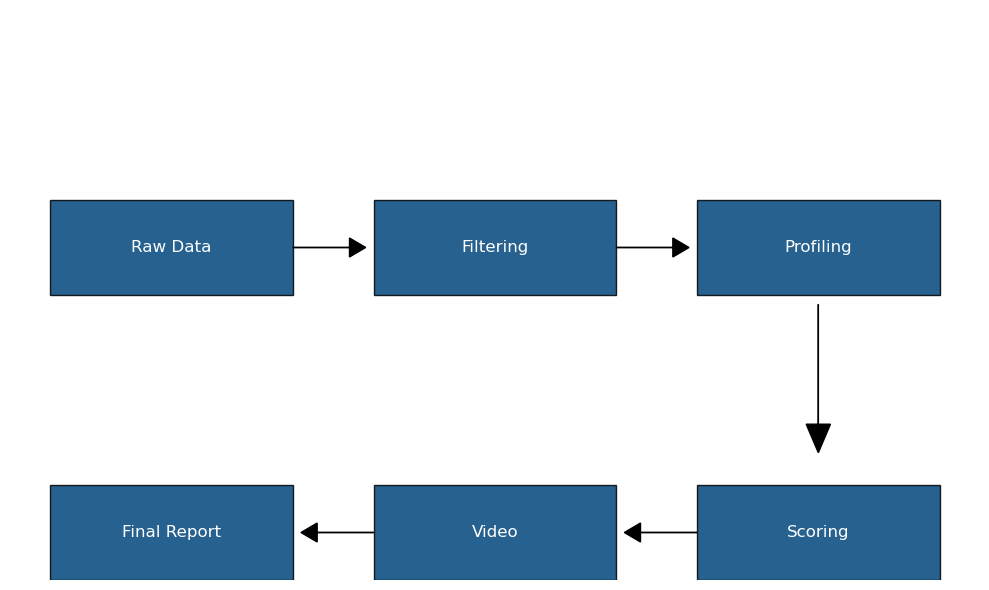

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

steps = [
    "Raw Data", "Filtering", "Profiling",
    "Final Report", "Video", "Scoring"
]

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

box_width = 3
box_height = 1
h_gap = 1  # horizontal gap between boxes
v_gap = 2  # vertical gap between rows

# Coordinates for top row (y fixed)
top_y = 6
bottom_y = top_y - box_height - v_gap

# Draw boxes and text
for i, step in enumerate(steps):
    col = i % 3
    row = i // 3
    x = 0.5 + col * (box_width + h_gap)
    y = top_y if row == 0 else bottom_y

    # Draw rectangle
    rect = Rectangle((x, y - box_height), box_width, box_height,
                     linewidth=1, edgecolor='black', facecolor='#00457C', alpha=0.85)
    ax.add_patch(rect)
    # Text
    ax.text(x + box_width / 2, y - box_height / 2, step,
            ha='center', va='center', fontsize=12, color='white')

    # Arrows
    if row == 0 and col < 2:
        # Top row: arrows pointing right
        ax.arrow(x + box_width, y - box_height / 2, h_gap * 0.7, 0,
                 head_width=0.2, head_length=0.2, fc='black', ec='black')
    elif row == 1 and col > 0:
        # Bottom row: arrows pointing left
        ax.arrow(x, y - box_height / 2, -h_gap * 0.7, 0,
                 head_width=0.2, head_length=0.2, fc='black', ec='black')

# Only one vertical arrow from last top box (col 2) — shortened length
col = 2
x = 0.5 + col * (box_width + h_gap) + box_width / 2
y_start = top_y - box_height - 0.1
arrow_length = (bottom_y + 0.1 - y_start) * 0.7  # 70% of original length
ax.arrow(x, y_start, 0, arrow_length,
         head_width=0.3, head_length=0.3, fc='black', ec='black')

ax.set_xlim(0, 12)
ax.set_ylim(2, 8)

plt.tight_layout()

# Save as PNG (300 dpi for good quality)
plt.savefig('scouting_process_flow.png', dpi=300, bbox_inches='tight')

plt.show()


In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# List of countries to highlight
highlight_countries = [
    "Spain", "Norway", "Sweden", "Denmark", "Finland",
    "Czechia", "Germany", "Netherlands", "Belgium", "Portugal"
]

# Filter for Europe (continent) — optional but focuses map better
europe = world[world['continent'] == 'Europe']

# Create a color column: red if in highlight_countries, else white (or transparent)
europe['color'] = europe['name'].apply(lambda x: 'red' if x in highlight_countries else 'white')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
europe.plot(ax=ax, color=europe['color'], edgecolor='black')

# Remove axes for cleaner look
ax.axis('off')

# Zoom in roughly to Europe extent
ax.set_xlim(-15, 35)
ax.set_ylim(34, 72)

# Save figure
plt.savefig('europe_highlighted_countries.png', dpi=300, bbox_inches='tight')

plt.show()


ModuleNotFoundError: No module named 'geopandas'

In [ ]:
pip install geopandas

  Using cached geopandas-1.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached pyogrio-0.11.0-cp312-cp312-macosx_12_0_x86_64.whl.metadata (5.3 kB)
  Using cached pandas-2.3.0-cp312-cp312-macosx_10_13_x86_64.whl.metadata (91 kB)
  Using cached pyproj-3.7.1.tar.gz (226 kB)
  Installing build dependencies ... done
